# Basic Algorithm for Risk-Based Authentication

&copy; 2022 Stephan Wiefling / [Data and Application Security Group](https://das.h-brs.de)

The code in this repository is licensed under the MIT License. See the [GitHub repository](https://github.com/das-group/rba-algorithm) for details.

## Prerequisites
### Import modules

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!unzip /content/drive/MyDrive/rba-dataset.zip

Archive:  /content/drive/MyDrive/rba-dataset.zip
replace LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [25]:
import pandas as pd
import math

from tqdm import tqdm
tqdm.pandas()

import copy
from functools import partial
import os

from collections import defaultdict

### Define additional functions that enhance pandas's functionality

We add custom functions to pandas, which can be very helpful when working with large datasets and high-performance computing clusters.

These can be called with:

- [var] = nested_dict()
- [pandas DataFrame].before_timestamp(...)
- [pandas DataFrame].between_timestamp(...)

In [26]:
"""`var = nested_dict()` creates a `dict` which auto-creates empty entries as list elements"""
nested_dict = lambda: defaultdict(list)

In [27]:
def __dataframe_values_before_timestamp(df, timestamp):
    """Query logs where time < timestamp (one element before timestamp)
    index of logs needs to be sorted and of type DateTimeIndex for best performance.

    INFO: timestamp must exist in the DataFrame, otherwise one element is lost.
    This is not changed due to optimizing performance in the RBA algorithm.

    timestamp -- timestamp (numpy.datetime64 or Date string)"""

    return df.loc[:timestamp][:-1]

pd.core.frame.DataFrame.before_timestamp = __dataframe_values_before_timestamp

In [28]:
def __dataframe_values_between_timestamp(df, timestamp_from, timestamp_to):
    """Query logs where timestamp_from > time < timestamp_to (one element before timestamp)
    index of logs needs to be sorted and of type DateTimeIndex for best performance.

    INFO: timestamp_to must exist in the DataFrame, otherwise one element is lost.
    This is not changed due to optimizing performance in the RBA algorithm.

    timestamp -- timestamp (numpy.datetime64 or Date string)"""
    return df.loc[timestamp_from:timestamp_to][:-1]

pd.core.frame.DataFrame.between_timestamp = __dataframe_values_between_timestamp

# Hashtable functions

In [29]:
class HashTable():

    def __init__(self):
        self.__hash_table = {}

In [30]:
class SubfeatureOccurenceHashTable(HashTable):

    def __init__(self, df, column_name, subfeature, subfeatures):
        self.__hash_table = {}
        self.__subfeature_table = {}

        # Column name
        self.__column_name = column_name

        # Subfeature belonging to this column name
        self.__subfeature = subfeature

        # List of all subfeatures belonging to this column name
        self.__subfeatures = subfeatures[column_name]

        # Create subfeature hash table
        self.__hash_table = df.groupby([self.__column_name, subfeature], dropna=False).apply(len)

        group = [self.__column_name, self.__subfeature]

        # Get position in list
        pos = self.__subfeatures.index(self.__subfeature)

        # Create list of subfeatures to use
        self.__subfeatures_to_use = self.__subfeatures[pos:]

        # Create subfeature table containing only the unique velues (We add true here to save space)
        self.__subfeature_table = df.groupby(self.__subfeatures_to_use, dropna=False).apply(lambda x: True)


    def get(self, subfeature, subfeature_value):
        """Get the occurence of a given column and subfeature value from the hash table

        column_name -- Column in hash table ("feature name")
        subfeature -- Subfeature in hash table
        subfeature_value -- Value of subfeature that we want to check the occurence for
        """
        try:
            # Extract occurence from hash table
            return self.__hash_table.loc[subfeature_value]
        except KeyError:
            # Value not found, so the occurence is zero
            return 0


    def increase(self, log):
        """Increase the occurences of subfeatures based on the log"""
        try:
            column_name_value = getattr(log, self.__column_name)

            # Get subfeature value from log
            subfeature_value = getattr(log, self.__subfeature)
        except AttributeError:
            print("ERROR: Subfeature or column name does not exist in log")

        # Get value from hash table
        try:
            # Increase value
            self.__hash_table.loc[(subfeature_value, column_name_value)] = self.__hash_table.loc[(subfeature_value, column_name_value)] + 1
        except (KeyError, TypeError):
            #  Key does not exist yet, so we start with 1
            self.__hash_table.loc[(subfeature_value, column_name_value)] = 1

            # Sort index
            self.__hash_table.sort_index(inplace=True)

        try:
            for subfeature in __subfeature_table.keys():
                # Get values of group hierarchy, start with first value in hierarchy
                group_values = [getattr(log, self.__column_name)]
                for pre_subfeature in self.__subfeatures:
                    # Append value for the pre-subfeature and subfeature
                    group_values.append(getattr(log, pre_subfeature))

                    if pre_subfeature == self.__subfeature:
                        # Abort when we reached this subfeature
                        break

                # Convert to tuple to address the values in table
                group_values = tuple(group_values)

                # Set value to true (adds new entry if not present)
                self.__subfeature_table[subfeature].loc[group_values] = True

                # Sort the table
                self.__subfeature_table[subfeature].sort_index(inplace=True)
        except:
            pass

    def len(self, subfeature_value):
        """Return the total number of values per subfeature value"""
        return self.get(self.__subfeature, subfeature_value).sum()

    def len_unique(self, next_subfeature):
        """Returns the number of unique values for a given subfeature"""
        if next_subfeature == self.__subfeature:
            # Calculate from hash table
            return len(self.__hash_table)
        else:
            # Take value from subfeature table
            return len(self.__subfeature_table[next_subfeature])

    def get_hash_table(self, subfeature_value):
        return self.__hash_table.loc[subfeature_value]

    def get_full_hash_table(self):
        return self.__hash_table


    def get_full_subfeature_table(self):
        return self.__subfeature_table

    def get_column_name(self):
        return self.__column_name

    def get_subfeatures(self):
        """Returns the list of subfeatures"""
        return self.__subfeatures

    def get_subfeatures_to_use(self):
        """Returns the list of subfeatures to use"""
        return self.__subfeatures_to_use


In [31]:
class OccurenceHashTable(HashTable):
    """Class for hash tables containing the occurences of column values inside a DataFrame"""

    def __init__(self, df, column_names=[], subfeatures={
        "requestXRealIP": ["ipASN", "ipCountry"],
        "trackingdatauserAgent": ["browser_name_version", "os_name_version", "device_type"]
        }):
        """Creates the hash table

        df -- pandas DataFrame
        column_name -- List of column names in df (default: Select all columns)
        """
        if len(column_names) == 0:
            # Take column names from all columns of DataFrame
            column_names = df.columns

        self.__hash_table = {}

        for column_name in column_names:
            #self.__hash_table[column_name] = pd.DataFrame(df.groupby(column_name, dropna=False).apply(len))[0]
            self.__hash_table[column_name] = df.groupby(column_name, dropna=False).size()

            # If column has subfeatures
            if column_name in subfeatures.keys():
                for subfeature in subfeatures[column_name]:
                    # Create subfeature hash tables
                    self.__hash_table[(column_name, subfeature)] = SubfeatureOccurenceHashTable(df, column_name, subfeature, subfeatures)

        # Total length of DataFrame
        self.__length = len(df)

        # Store the list of subfeatures
        self.__subfeatures = subfeatures

    def __str__(self):
        return str(self.__hash_table)

    def get(self, column_name, value):
        """Get the occurence of a given column value from the hash table

        column_name -- Column in hash table ("feature name")
        value -- Value that we want to check the occurence for
        """
        try:
            return self.__hash_table[column_name].loc[value]
        except KeyError:
            # Value not found, so the occurence is zero
            return 0

    def get_hash_table(self, column_name):
        """Returns the hash table for the column name"""
        return self.__hash_table[column_name]

    def get_subfeature_hash_table(self, column_name, subfeature):
        """Returns the hash table for the column name"""
        return self.__hash_table[(column_name, subfeature)]

    def len_unique(self, column_name):
        """Return the number of unique values in hash table column

        column_name -- Column in hash table ("feature name")
        """
        return len(self.__hash_table[column_name])

    def len(self):
        """Return the total number of values per hash table column
        """
        return self.__length

    def increase(self, log):
        """Increase the hash table values based on the log values

        log -- New log entry
        """
        # For each value
        for key, value in log._asdict().items():
            # Add value only when key is in the hash table
            if key in self.__hash_table:
                try:
                    # Increase value
                    self.__hash_table[key].loc[value] = self.__hash_table[key].loc[value] + 1
                except KeyError:
                    #  Key does not exist yet, so we start with 1
                    self.__hash_table[key].loc[value] = 1

                    # Sort index
                    self.__hash_table[key].sort_index(inplace=True)

                # TODO: Increase subfeature values
                if key in self.__subfeatures.keys():
                    for subfeature in self.__subfeatures[key]:
                        # Create subfeature hash tables
                        self.get_subfeature_hash_table(key, subfeature).increase(log)

        # Increase length of hash table
        self.__length = self.__length + 1

In [32]:
class SubfeatureOccurenceHashTableHelper:
    """Helper class to adjust functions to RBA algorithm function calls"""

    def __init__(self, hash_table, column_name, subfeature, subfeature_value, login_attempt):
        """Constructor

        subfeature_occurence_hash_table -- SubfeatureOccurenceHashTable
        subfeature_value -- subfeature value that we should adjust the functions to
        """
        # Global hash table
        self.__hash_table = hash_table

        # Subfeature hash table
        self.__subfeature = subfeature
        self.__subfeature_occurence_hash_table = self.__hash_table.get_subfeature_hash_table(column_name, self.__subfeature)
        self.__subfeature_value = subfeature_value

        # Current login attempt
        self.__login_attempt = login_attempt

    def len(self):
        #print(self.__subfeature_value)
        # Filter by subfeature value
        return self.get(self.__subfeature, self.__subfeature_value)

    def get(self, feature, feature_value):
        #raise NotImplementedError("Function get() is not implemented at the moment.")
        # global_hash_table.get("ipASN", 2119.0)
        return self.__hash_table.get(feature, feature_value)

    def len_unique(self, next_subfeature):
        # Reproduce subfeature values from prior subfeatures

        # Get list of subfeatures
        subfeatures_to_use = self.get_subfeature_occurence_hash_table().get_subfeatures()

        # Filter the list to only use the features before the next subfeature
        subfeatures_to_use = subfeatures_to_use[:subfeatures_to_use.index(next_subfeature)]

        # Build the list of values
        values = []

        # Iterate through this list
        for subfeature in subfeatures_to_use:
            # Append the feature value for current feature
            values.append(getattr(self.__login_attempt, subfeature))

        # Convert to tuple to that we can index in hash table
        values = tuple(values)

        # Nested subfeature values
        try:
            return len(self.get_subfeature_occurence_hash_table().get_full_subfeature_table().loc[values])
        except KeyError as e:
            if e != "nan":
                # Subfeature value does not exist in table
                return 0.0

    def get_hash_table(self):
        return self.__subfeature_occurence_hash_table.get_hash_table(self.__subfeature_value)

    def get_subfeature_occurence_hash_table(self):
        return self.__subfeature_occurence_hash_table

# Risk-Based Authentication (RBA) Algorithm

This is our RBA implementation following the instructions given in [Freeman et al. (2016)](https://doi.org/10.14722/ndss.2016.23240). The original implementation was never published. Therefore, we cannot be sure that it is identical with the one in Freeman et al., especially with the edge cases that we discovered and addressed here.

The code below was used in Wiefling et al. ([2022](https://doi.org/10.1145/3546069)) and was performance optimized from the version in Wiefling et al. ([2021a](https://pub.h-brs.de/files/5956/Wiefling2021_WhatsInScoreForWebsiteUsers-Postproceedings.pdf), [2021b](https://nbn-resolving.org/urn:nbn:de:hbz:1044-opus-58417)). See the publications for further details.

In [33]:
"""
Weightings for the risk score calculation. These values are set for
our RBA data set, which you can obtain at
https://github.com/das-group/rba-dataset
"""
feature_weightings = {
    "requestXRealIP": {
        "requestXRealIP": 0.6,
        "ipASN": 0.3,
        "ipCountry": 0.1
    },
    "trackingdatauserAgent": {
        'trackingdatauserAgent': 0.5386653840551359,
        'browser_name_version': 0.2680451498625666,
        'os_name_version': 0.18818295100109536,
        'device_type': 0.0051065150812021525
    },
}

risk_score_weightings = {
    'requestXRealIP': 1,
    'trackingdatauserAgent': 1
}

In [34]:
def get_unseen_values(login_history, feature, hash_table=None):
    # Look for posible subfeatures
    for __feature in feature_weightings.keys():
        # Iterate through all possible subfeature names
        i=0
        for subfeature in feature_weightings[__feature].keys():
            # Exit this loop when we reached the end of the iteration
            if i > len(feature_weightings[__feature].keys())-2:
                break

            # When we found the feature that we were looking for
            if feature == subfeature:
                # Get the next subfeature to jump to
                next_subfeature = list(feature_weightings[__feature].keys())[i+1]

                # Do recursion
                try:
                    return hash_table.len_unique(next_subfeature) + get_unseen_values(login_history, next_subfeature, hash_table)
                except (AttributeError, NotImplementedError) as e:
                    # Hash table or hash table function does not exist, so we use the slower algorithm instead
                    return len(login_history[next_subfeature].unique()) + get_unseen_values(login_history, next_subfeature, hash_table)
            i+=1

    # No subfeatures found. So we only assume one unseen value.
    return 1

def get_likelihood(login_history, login_attempt, feature, smoothing=True, hash_table=None):
    # Get the feature value of login attempt
    feature_value = getattr(login_attempt, feature)

    try:
        appearance = hash_table.get(feature, feature_value)
    except (AttributeError, NotImplementedError) as e:
        # Hash table or hash table function does not exist, so we use the slower algorithm instead
        appearance = len(login_history.query("{} == @feature_value".format(feature)))

    if smoothing == True or appearance == 0:
        unseen = get_unseen_values(login_history, feature, hash_table)
    else:
        unseen = 0

    try:
        num_logs = hash_table.len()
    except (AttributeError, NotImplementedError) as e:
        num_logs = len(login_history)

    if appearance > 0:
        likelihood = appearance/num_logs
        likelihood *= (1 - (unseen/(num_logs+unseen)))
    else:
        if smoothing == True:
            likelihood = 1/(num_logs+unseen)
        else:
            # Feature does not appear at all and is not smoothed
            likelihood = 0.0

    return likelihood

def get_sub_likelihood(user_logs, login_attempt, feature, feature_value, subfeature, smoothing=True, hash_table=None):
    subfeature_value = getattr(login_attempt, subfeature)

    try:
        hash_table_subfeature = SubfeatureOccurenceHashTableHelper(hash_table, feature, subfeature, subfeature_value, login_attempt)
    except:
        hash_table_subfeature = None

    if hash_table_subfeature == None:
        user_logs_subfeature = user_logs.query("{} == @subfeature_value".format(subfeature))
    else:
        user_logs_subfeature = None

    likelihood_user_subfeature = get_likelihood(user_logs_subfeature, login_attempt, subfeature, smoothing=smoothing, hash_table=hash_table_subfeature)
    likelihood_subfeature = get_likelihood(user_logs, login_attempt, subfeature, smoothing=smoothing, hash_table=hash_table)

    return likelihood_user_subfeature*likelihood_subfeature

def get_minimum_likelihood(login_history, feature, smoothing=True, hash_table=None):
    """Returns the minimum possible likelihood for a given feature"""
    num_logs = len(login_history)

    if smoothing == True:
        unseen = get_unseen_values(login_history, feature, hash_table)
    else:
        unseen = 0
    if num_logs + unseen == 0:
        return 1.0  # Default likelihood for unseen cases
    return 1 / (num_logs + unseen)


def get_minimum_sub_likelihood(login_history, feature, subfeature, hash_table=None):
    """Returns the minimum possible likelihood for a given subfeature"""
    # Calculate likelihood that feature is of subfeature
    likelihood_user_subfeature = get_minimum_likelihood(login_history, subfeature, smoothing=False, hash_table=hash_table)

    # Calculate likelihood of subfeature
    likelihood_subfeature = get_minimum_likelihood(login_history, subfeature, hash_table=hash_table)

    return likelihood_user_subfeature*likelihood_subfeature

def freeman_rba_score(login_attempt, user_logs, global_logs, num_users, features=["requestXRealIP", "trackingdatauserAgent"], global_hash_table=None):
    """Return risk score based on Freeman et al.'s model
    (Equation 7, without per-member attack data)

    Keyword arguments:
    login_attempt -- Pandas DataFrame containing current login attempt
    user_logs -- Pandas DataFrame containing past login sessions of user
    global_logs -- Pandas DataFrame containing all login sessions of all users
    num_users -- number of users in the global login history
    features -- Python list of features to be evaluated
    global_hash_table -- Hash table containing the global occurences per feature and feature value (generated by create_occurence_hash_table(...))

    return -- Risk score"""

    if isinstance(login_attempt, pd.Series):
        print("ERROR: login_attempt is a pandas Series. This breaks the functionality of the hash table. Abort.")
        return

    # Probability of how likely this feature value is used by an attacker
    # We don't have any data here, so we don't weigh it here
    feature_value_attack_probability = 1


    # Get ID of user
    userid = user_logs.head(1)["userid"].squeeze()

    risk_score = 1.0
    # Iterate through each feature
    for feature in features:
        # Get the feature value of login attempt
        feature_value = getattr(login_attempt, feature)

        # Calculate how likely this feature value appears in user's login history
        local_unseen = get_unseen_values(user_logs, feature)
        num_user_logs = len(user_logs)

        local_likelihood = get_likelihood(user_logs, login_attempt, feature)
        minimum_likelihood = get_minimum_likelihood(user_logs, feature)

        # If we have subsets in a feature, we process them
        if feature in feature_weightings:
            local_likelihood = 0.0
            minimum_likelihood = 0.0

            # Level in feature hierarchy
            smoothing = False
            for subfeature in feature_weightings[feature]:
                subfeature_value = getattr(login_attempt, subfeature)

                __local_likelihood = feature_weightings[feature][subfeature] * get_sub_likelihood(user_logs, login_attempt, "requestXRealIP", feature_value, subfeature, smoothing=smoothing)
                local_likelihood += math.pow(__local_likelihood, risk_score_weightings[feature])

                __minimum_likelihood = feature_weightings[feature][subfeature] * get_minimum_sub_likelihood(user_logs, feature, subfeature)
                minimum_likelihood += math.pow(__minimum_likelihood, risk_score_weightings[feature])

                # We only smooth the first element in hierarchy
                smoothing = False

        # Calculate how likely this feature value appears in global login history
        if global_hash_table != None:
            num_global_logs = global_hash_table.len()
        else:
            num_global_logs = len(global_logs)

        global_likelihood = get_likelihood(global_logs, login_attempt, feature, hash_table=global_hash_table)

        # In cases where we have subsets of features
        if feature in feature_weightings:
            global_likelihood = 0.0
            smoothing = True
            for subfeature in feature_weightings[feature]:
                sub_likelihood = get_sub_likelihood(global_logs, login_attempt, feature, feature_value, subfeature, smoothing=smoothing, hash_table=global_hash_table)

                __global_likelihood = feature_weightings[feature][subfeature] * sub_likelihood
                global_likelihood += math.pow(__global_likelihood, risk_score_weightings[feature])

                # We only smooth the first element in hierarchy
                smoothing = False

        if local_likelihood == 0.0:
            """
            Edge case: The feature value never appeared in the user's login history.
            Smoothing this value, however, would result in a low risk score when local
            and global value both have to be smoothed. So we make sure that the risk
            score for this edge case is high.
            """
            local_likelihood = global_likelihood / 4

        # Calculate part of risk score for feature
        risk_score *= global_likelihood/local_likelihood

    # Likelihood of user logging in
    user_login_likelihood = num_user_logs/num_global_logs

    # We assume that all users are to be attacked equally
    attack_likelihood = 1/num_users

    if user_login_likelihood == 0:
      user_login_likelihood = 1e-9  # Small constant to avoid division by zero
    risk_score = risk_score * (attack_likelihood / user_login_likelihood)

    return risk_score

# Comparative testing
We test Freeman's RBA model by calculating EER (Equal Error Rate).

Loading dataset...
Precomputing user login histories...
Computing RBA risk scores...
Classification Report:
              precision    recall  f1-score   support

       False       0.81      0.60      0.69      5415
        True       0.64      0.83      0.72      4585

    accuracy                           0.70     10000
   macro avg       0.72      0.71      0.70     10000
weighted avg       0.73      0.70      0.70     10000

AUC-ROC Score: 0.7600


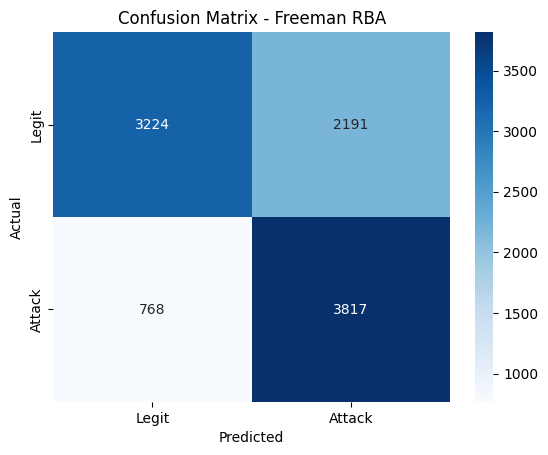

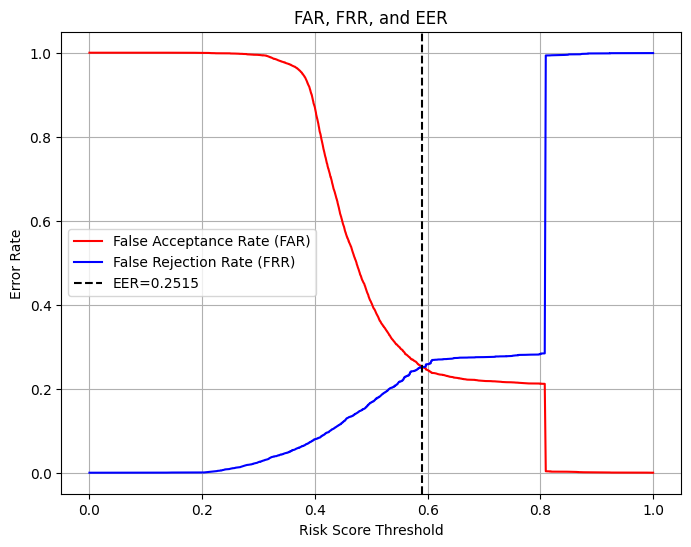

Equal Error Rate (EER): 0.2515 at threshold 0.5908
Processing complete.


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import MinMaxScaler

# Load dataset
print("Loading dataset...")
df = pd.read_csv("/content/rba-dataset.csv", skiprows=range(1,50001), nrows=10000)

# Rename columns to match Freeman's RBA implementation
def rename_columns(logs):
    logs.rename(columns={
        "User ID": "userid",
        "IP Address": "requestXRealIP",
        "ASN": "ipASN",
        "Country": "ipCountry",
        "User Agent String": "trackingdatauserAgent",
        "Browser Name and Version": "browser_name_version",
        "OS Name and Version": "os_name_version",
        "Device Type": "device_type"
    }, inplace=True)

rename_columns(df)
df.sort_values("Login Timestamp", inplace=True)

# Wrapper class to allow attribute-style access for the risk function
class LoginAttempt:
    def __init__(self, series):
        for key, value in series.items():
            setattr(self, key, value)

# Precompute user login histories in a dictionary.
print("Precomputing user login histories...")
user_histories = defaultdict(list)

def compute_rba_scores(df):
    risk_scores = []
    num_users = df["userid"].nunique()

    for idx, attempt in df.iterrows():
        user_id = attempt["userid"]
        timestamp = attempt["Login Timestamp"]

        user_logs_df = pd.DataFrame(user_histories[user_id]) if user_histories[user_id] else pd.DataFrame(columns=df.columns)

        if user_logs_df.empty:
            risk_scores.append(1.0)  # Assign highest risk if no prior data
        else:
            # Using the freeman_rba_score function as implemented by DAS
            risk_score = freeman_rba_score(LoginAttempt(attempt), user_logs_df, df, num_users)
            risk_scores.append(risk_score)

        # Update history for this user
        user_histories[user_id].append(attempt.to_dict())

    df["risk_score"] = risk_scores
    return df

print("Computing RBA risk scores...")
df = compute_rba_scores(df)

# We store the raw risk scores before applying any transformations
df["raw_risk_score"] = df["risk_score"]

# Apply a log transform to spread out tiny values, then re-scale
# to [0,1] with MinMaxScaler. Add a small epsilon to avoid log(0).
epsilon = 1e-9
df["risk_score"] = np.log(df["raw_risk_score"] + epsilon)

scaler = MinMaxScaler()
df["risk_score"] = scaler.fit_transform(df[["risk_score"]])

# Evaluate model using actual ground truth labels
y_true = df["Login Successful"].values
# We'll classify as 'attack' if risk_score > 0.5, just to show the
# confusion matrix at threshold=0.5
y_pred = (df["risk_score"] > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_true, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_true, df['risk_score']):.4f}")

# Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legit", "Attack"], yticklabels=["Legit", "Attack"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Freeman RBA")
plt.show()

# Compute ROC curve and EER (no drop_intermediate)
fpr, tpr, thresholds = roc_curve(y_true, df["risk_score"], drop_intermediate=False)
frr = 1 - tpr

# Find threshold that minimizes |FPR - FRR|
eer_index = np.nanargmin(np.abs(fpr - frr))
eer = (fpr[eer_index] + frr[eer_index]) / 2
eer_threshold = thresholds[eer_index]

# Plot FAR/FRR vs. threshold
plt.figure(figsize=(8, 6))
plt.plot(thresholds, fpr, label="False Acceptance Rate (FAR)", color="red")
plt.plot(thresholds, frr, label="False Rejection Rate (FRR)", color="blue")
plt.axvline(eer_threshold, color="black", linestyle="--", label=f"EER={eer:.4f}")
plt.xlabel("Risk Score Threshold")
plt.ylabel("Error Rate")
plt.legend()
plt.title("FAR, FRR, and EER")
plt.grid()
plt.show()

print(f"Equal Error Rate (EER): {eer:.4f} at threshold {eer_threshold:.4f}")
print("Processing complete.")

# Example using RBA data set

We show an example test case using our RBA data set, which you can obtain at https://github.com/das-group/rba-dataset

Extract the data set's ZIP file contents to a `rba-dataset` folder inside the folder of this Jupyter Notebook to run the example code.

## Import data

In [ ]:
def rename_columns(logs):
    """
    Rename columns to match the names inside the algorithm.
    """
    logs.rename(columns={
        "User ID": "userid",
        "IP Address": "requestXRealIP",
        "ASN": "ipASN",
        "Country": "ipCountry",
        "User Agent String": "trackingdatauserAgent",
        "Browser Name and Version": "browser_name_version",
        "OS Name and Version": "os_name_version",
        "Device Type": "device_type"
    }, inplace=True)

__columns_to_use = [
    "Login Timestamp",
    "User ID",
    "IP Address",
    "Country",
    "ASN",
    "User Agent String",
    "Browser Name and Version",
    "OS Name and Version",
    "Device Type",
    "Login Successful"
]

global_logs = pd.read_csv(
    #"./rba-dataset/rba-dataset.csv",
    "/content/rba-dataset.csv",
    index_col="Login Timestamp",
    parse_dates=True,
    usecols=__columns_to_use,
    nrows=1000000
)

# Drop all invalid values
global_logs.dropna(inplace=True)

# We only consider successful login attempts for our risk score calculation
global_logs = global_logs[global_logs['Login Successful'] == True]
rename_columns(global_logs)

# Sort the values by timestamp to fasten accessing the values (binary search)
global_logs.sort_index(inplace=True)

# Get all userids
user_ids = global_logs["userid"].unique()

print("Users: ", len(user_ids))
print("Sessions: ", len(global_logs))
print()
global_logs.info()

**Note:** As you can see in the data columns listing above, many columns are of `object` Dtype. You can further improve the performance by hashing the values of these columns and store them as `int64`. See [Wiefling et al. (2022)](https://doi.org/10.1145/3546069) for more information.

## Test risk scores for legitimate logins
### Define test function

In [ ]:
# Group global logs by userid to save time with each iteration
global_logs_groupby_userid = global_logs.groupby("userid")

In [ ]:
def login_test_single(slice_start, slice_size, features=["requestXRealIP", "trackingdatauserAgent"]):
    """Login test (risk scores for legitimate logins): single execution
    Feel free to include this function in a Python multiprocessing
    environment to unleash multi-core calculation power.

    slice_start -- Start position of the slice
    slice_size -- Size of the slice
    """

    # Create hash table at start of calculation

    # We have to extract the global login history before the starting point of our login test
    __logs = global_logs.iloc[:slice_start]

    # Get log entries until end of slice size
    __login_attempts = global_logs.iloc[slice_start:slice_start+slice_size]

    # Create hash table
    global_hash_table = OccurenceHashTable(__logs, __logs.columns)

    # Table containing the risk score results
    risk_score_results = nested_dict()

    # Iterate for each login attempt
    i = 1

    for login_attempt in __login_attempts.itertuples():
        # Extract log for userid
        userid = getattr(login_attempt, "userid")

        # Extract timestamp
        timestamp = getattr(login_attempt, "Index")

        # Get logs for user
        user_logs = global_logs_groupby_userid.get_group(userid).before_timestamp(timestamp)

        # Login attempt number
        login_attempt_number = len(user_logs) + 1

        #Login successful
        login_successful = getattr(login_attempt, "Login Successful")

        # Only execute when we have more than one login attempt for user
        if login_attempt_number > 1:
            # Get number of users from hash table
            num_users = global_hash_table.len_unique("userid")

            # Execute RBA
            risk_score = freeman_rba_score(login_attempt, user_logs, global_logs, num_users, features=features, global_hash_table=global_hash_table)

            # Add risk score to results
            risk_score_results["userid"].append(userid)
            risk_score_results["sessionStart"].append(timestamp)
            risk_score_results["login_attempt_number"].append(login_attempt_number)
            risk_score_results["risk_score"].append(risk_score)
            risk_score_results["login successful"].append(login_successful)

        # Add login attempt to hash table and increase the feature value counts here
        global_hash_table.increase(login_attempt)

        # Increase the log entries to include the current login attempt
        __logs = global_logs.head(slice_start+i)

        # Increase login attempt counter
        i+=1

    return pd.DataFrame(risk_score_results)

## Run the test

We calculate the risk scores for the data set entries 50001-50051 and check whether the calculated risk scores are as expected.

In [ ]:
test_result = login_test_single(50000, 50)
display(test_result)

expected_result = [
    0.001735608896331267,
    0.0003131930911696338,
    0.00038481209981864445,
    0.00023380343388881817,
    0.0062984271682455266,
    0.024024171011906934,
    0.36241860205465537,
    0.0003489615152250577,
    0.00048701529441907065,
    1.2462230273339967,
    0.00025999322274249494,
    0.00021976714969851479,
    0.47014766381586093,
    0.0009798412309385818,
    0.0841229474444737,
    0.4421278704947991,
    0.01472119251257646,
    0.03366013914910071,
    0.000483684972634349,
    0.0002568913432172573,
    0.0045807146185027755,
    1.176522284255606e-05,
    0.0006543352945740962,
    0.0009051562075623795
]

if test_result["risk_score"].to_list() == expected_result:
    print("Test success: Risk scores are as expected")
else:
    print("Test failed: Risk scores are not as expected")

# Another metrics test version

In [ ]:
import pandas as pd

# Load the dataset
try:
    global_logs = pd.read_csv(
        "/content/rba-dataset.csv",
        index_col="Login Timestamp",
        parse_dates=True,
        nrows=50000
    )
    print("Dataset loaded successfully!")
    print("Columns in dataset:", global_logs.columns.tolist())
    print("First 5 rows:")
    display(global_logs.head())
except Exception as e:
    print(f"Error loading dataset: {e}")

In [ ]:
# Check if required columns exist
required_columns = [
    "User ID", "IP Address", "Country", "ASN",
    "User Agent String", "Browser Name and Version",
    "OS Name and Version", "Device Type", "Login Successful"
]

missing_columns = [col for col in required_columns if col not in global_logs.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    print("All required columns are present.")

In [ ]:
# ======================
# Optimized RBA Evaluation
# ======================

import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Optimized data loading with dtype specification
DTYPES = {
    'User ID': 'int64',
    'IP Address': 'category',
    'Country': 'category',
    'ASN': 'int32',
    'User Agent String': 'category',
    'Browser Name and Version': 'category',
    'OS Name and Version': 'category',
    'Device Type': 'category',
    'Login Successful': 'bool'
}

def load_data():
    """Load dataset with optimized data types and chunking"""
    try:
        return pd.read_csv(
            "/content/rba-dataset.csv",
            index_col="Login Timestamp",
            parse_dates=True,
            dtype=DTYPES,
            nrows=20000  # Start with subset for testing
        )
    except FileNotFoundError:
        raise FileNotFoundError("Dataset not found at specified path")

# Vectorized feature engineering
def preprocess_data(df):
    """Optimized preprocessing pipeline"""
    # Drop NA in critical columns
    critical_cols = ['User ID', 'IP Address', 'Login Successful']
    df = df.dropna(subset=critical_cols)

    # Convert to categoricals
    for col in ['Country', 'Device Type']:
        df[col] = df[col].astype('category')

    # Ensure unique timestamps by adding a small offset to duplicates
    df.index = df.index + pd.to_timedelta(df.groupby(level=0).cumcount(), unit='ms')

    return df

# Parallelized risk score calculation
def parallel_risk_calculation(user_group):
    """Calculate risk scores for a user group in parallel"""
    user_id, user_logs = user_group
    risk_scores = []

    # Use vectorized operations instead of iterrows
    timestamps = user_logs.index.values
    login_attempts = user_logs.itertuples()

    for attempt in login_attempts:
        # Simplified risk calculation logic
        hist = user_logs.loc[:attempt.Index].iloc[:-1]

        # Vectorized feature analysis
        ip_risk = hist['IP Address'].value_counts(normalize=True).get(getattr(attempt, 'IP_Address', None), 0)
        device_risk = hist['Device Type'].value_counts(normalize=True).get(getattr(attempt, 'Device_Type', None), 0)

        risk_score = 1 - (0.6 * ip_risk + 0.4 * device_risk)
        risk_scores.append((attempt.Index, risk_score))

    return pd.DataFrame(risk_scores, columns=['timestamp', 'risk_score']).assign(user_id=user_id)

def optimized_evaluation():
    """Optimized end-to-end evaluation pipeline"""
    start_time = time.time()

    # Load and preprocess
    df = load_data()
    print(f"Data loaded in {time.time() - start_time:.1f}s")

    df = preprocess_data(df)
    print(f"Data preprocessed in {time.time() - start_time:.1f}s")

    # Parallel processing by user
    user_groups = list(df.groupby('User ID'))

    results = Parallel(n_jobs=-1, verbose=1)(
        delayed(parallel_risk_calculation)(group)
        for group in user_groups
    )

    # Combine results
    results_df = pd.concat(results)

    # Ensure unique timestamps in results
    results_df['timestamp'] = results_df['timestamp'] + pd.to_timedelta(results_df.groupby('timestamp').cumcount(), unit='ms')
    results_df = results_df.set_index('timestamp')

    print(f"Risk scores calculated in {time.time() - start_time:.1f}s")

    # Merge with labels
    results_df['label'] = df['Login Successful'].astype(int)

    # Evaluation metrics
    evaluate_performance(results_df)

    return results_df

def evaluate_performance(results_df):
    """Optimized performance evaluation with proper visualizations"""
    y_true = results_df['label'].values
    y_scores = results_df['risk_score'].values

    # Calculate metrics
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    roc_auc = roc_auc_score(y_true, y_scores)

    # Calculate EER
    frr = 1 - tpr  # False Rejection Rate
    eer_idx = np.nanargmin(np.abs(fpr - frr))
    eer = (fpr[eer_idx] + frr[eer_idx]) / 2
    eer_threshold = thresholds[eer_idx]

    # Generate predictions at EER threshold
    y_pred = (y_scores >= eer_threshold).astype(int)

    # Create figure
    plt.figure(figsize=(18, 6))

    # 1. ROC Curve with EER Marker
    plt.subplot(1, 3, 1)
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.scatter(fpr[eer_idx], tpr[eer_idx], color='red',
                label=f'EER = {eer:.2f} @ Threshold {eer_threshold:.2f}')
    plt.xlabel('False Positive Rate (FAR)')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # 2. Confusion Matrix
    plt.subplot(1, 3, 2)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Attack', 'Predicted Legit'],
                yticklabels=['Actual Attack', 'Actual Legit'])
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title(f'Confusion Matrix @ Threshold = {eer_threshold:.2f}')

    # 3. FAR/FRR Curve
    plt.subplot(1, 3, 3)
    plt.plot(thresholds, fpr, label='FAR')
    plt.plot(thresholds, frr, label='FRR')
    plt.axvline(eer_threshold, color='red', linestyle='--',
                label=f'EER Threshold ({eer_threshold:.2f})')
    plt.xlabel('Risk Threshold')
    plt.ylabel('Error Rate')
    plt.title('FAR and FRR vs. Threshold')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Equal Error Rate (EER): {eer:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Attack', 'Legit']))

# Re-run evaluation with fixed function
results_df = optimized_evaluation()
evaluate_performance(results_df)